In [78]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
plt.close('all')

d = np.linspace(0,100,11)

df1 = pd.read_csv("Physician_Compare_National_Downloadable_File.csv", low_memory=False)
df2 = pd.read_csv("Physician_Compare_2015_Individual_EP_Public_Reporting___Performance_Scores.csv", low_memory=False)

In [79]:
female = df1.loc[(df1["Gender"]=="F"), ["Gender"]]
female_accept = df1.loc[(df1["Gender"]=="F") & (df1["Professional accepts Medicare Assignment"]=="Y"), ["NPI","PAC ID","Medical school name","Graduation year"]]
male = df1.loc[(df1["Gender"]=="M"), ["Gender"]]
male_accept = df1.loc[(df1["Gender"]=="M") & (df1["Professional accepts Medicare Assignment"]=="Y"), ["NPI","PAC ID","Medical school name","Graduation year"]]
am = df1.loc[(df1["Gender"]=="M") & (df1["Professional accepts Medicare Assignment"]=="Y"), ["NPI","Medical school name","Graduation year"]]
af = df1.loc[(df1["Gender"]=="F") & (df1["Professional accepts Medicare Assignment"]=="Y"), ["NPI","Medical school name","Graduation year"]]
df2_flu = df2.loc[(df2["Measure Title"]=="Preventive Care and Screening: Influenza Immunization"),["NPI","Measure Performance Rate"]]
df3_pneuvacc = df2.loc[(df2["Measure Title"]=="Pneumonia Vaccination Status for Older Adults"),["NPI","Measure Performance Rate"]]
df4_brcanc = df2.loc[(df2["Measure Title"]=="Breast Cancer Screening"),["NPI","Measure Performance Rate"]]
df5_colocanc = df2.loc[(df2["Measure Title"]=="Colorectal Cancer Screening"),["NPI","Measure Performance Rate"]]
df6_bmi = df2.loc[(df2["Measure Title"]=="Preventive Care and Screening: Body Mass Index (BMI) Screening and Follow-Up Plan"),["NPI","Measure Performance Rate"]]
df7_currmeds = df2.loc[(df2["Measure Title"]=="Documentation of Current Medications in the Medical Record"),["NPI","Measure Performance Rate"]]
df8_eldmal = df2.loc[(df2["Measure Title"]=="Elder Maltreatment Screen and Follow-Up Plan"),["NPI","Measure Performance Rate"]]
df9_tobacco = df2.loc[(df2["Measure Title"]=="Preventive Care and Screening: Tobacco Use: Screening and Cessation Intervention"),["NPI","Measure Performance Rate"]]
df10_osteo = df2.loc[(df2["Measure Title"]=="Screening or Therapy for Osteoporosis for Women Aged 65 Years and Older"),["NPI","Measure Performance Rate"]]
df11_ecg = df2.loc[(df2["Measure Title"]=="Emergency Medicine: 12-Lead Electrocardiogram (ECG) Performed for Non-Traumatic Chest Pain"),["NPI","Measure Performance Rate"]]

In [91]:
df59=pd.merge(df5_colocanc, df9_tobacco, on='NPI').drop_duplicates().dropna()
df59.columns=[c.replace(' ', '_') for c in df59.columns]
df23=pd.merge(df2_flu, df3_pneuvacc, on='NPI').drop_duplicates().dropna()
df23.columns=[c.replace(' ', '_') for c in df23.columns]
brcancm=pd.merge(am, df4_brcanc, on='NPI').drop_duplicates().dropna()
brcancm.columns=[c.replace(' ', '_') for c in brcancm.columns]
brcancf=pd.merge(af, df4_brcanc, on='NPI').drop_duplicates().dropna()
brcancf.columns=[c.replace(' ', '_') for c in brcancm.columns]
flum=pd.merge(am, df2_flu, on='NPI').drop_duplicates().dropna()
flum.columns=[c.replace(' ', '_') for c in flum.columns]
fluf=pd.merge(af, df2_flu, on='NPI').drop_duplicates().dropna()
fluf.columns=[c.replace(' ', '_') for c in fluf.columns]

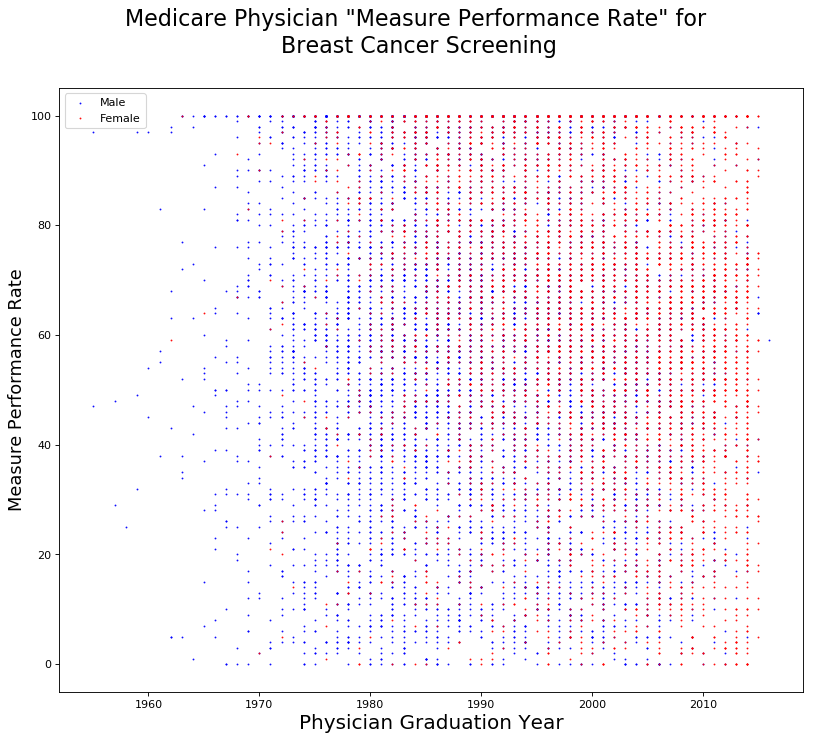

In [81]:
fig1=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
fig1.suptitle('Medicare Physician "Measure Performance Rate" for \nBreast Cancer Screening', fontsize=20)
plt.xlabel('Physician Graduation Year', fontsize=18)
plt.ylabel('Measure Performance Rate', fontsize=16)
ax1=plt.scatter(brcancm.Graduation_year, brcancm.Measure_Performance_Rate, c='blue', s=0.4, label="Male")
ax2=plt.scatter(brcancf.Graduation_year, brcancf.Measure_Performance_Rate, c='red', s=0.4, label="Female")
plt.gca().legend()
plt.show()

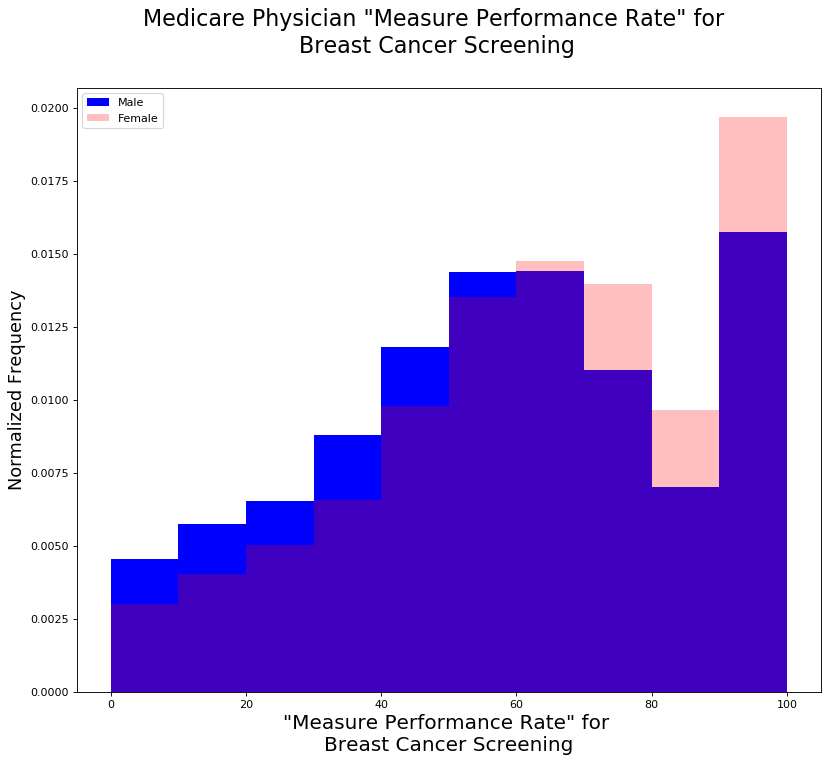

In [86]:
fig2=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
fig2.suptitle('Medicare Physician "Measure Performance Rate" for \nBreast Cancer Screening', fontsize=20)
plt.xlabel('"Measure Performance Rate" for \nBreast Cancer Screening', fontsize=18)
plt.ylabel('Normalized Frequency', fontsize=16)
ax3=plt.hist(brcancm.Measure_Performance_Rate, label="Male", bins=d, color='blue', normed=True)
ax4=plt.hist(brcancf.Measure_Performance_Rate, label="Female", bins=d, color='red', normed=True, alpha=0.25)
plt.gca().legend()
plt.show()

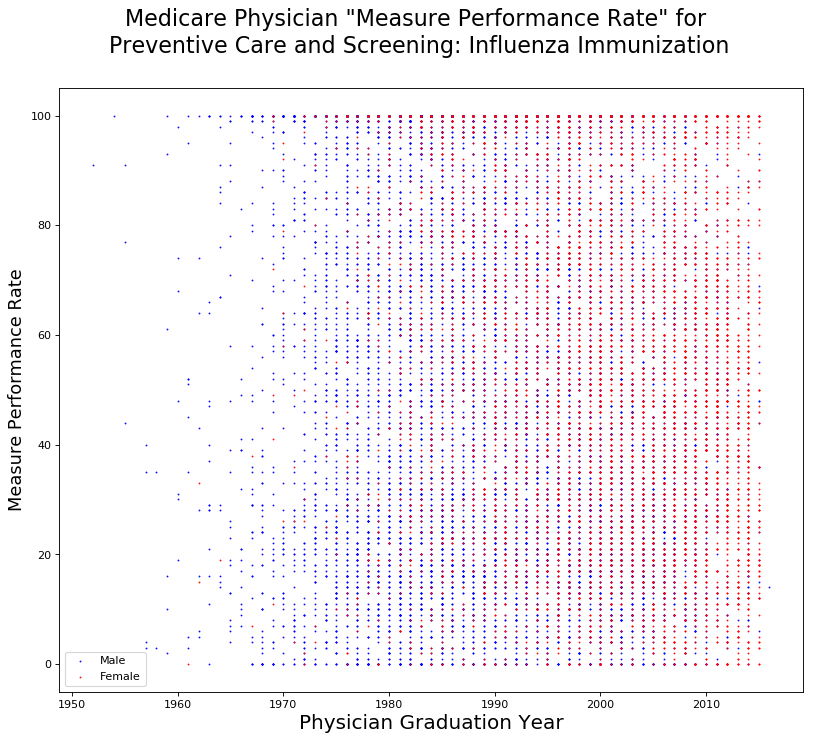

In [87]:
fig3=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
fig3.suptitle('Medicare Physician "Measure Performance Rate" for \nPreventive Care and Screening: Influenza Immunization', fontsize=20)
plt.xlabel('Physician Graduation Year', fontsize=18)
plt.ylabel('Measure Performance Rate', fontsize=16)
ax5=plt.scatter(flum.Graduation_year, flum.Measure_Performance_Rate, c='blue', s=0.4, label="Male")
ax6=plt.scatter(fluf.Graduation_year, fluf.Measure_Performance_Rate, c='red', s=0.4, label="Female")
plt.gca().legend()
plt.show()

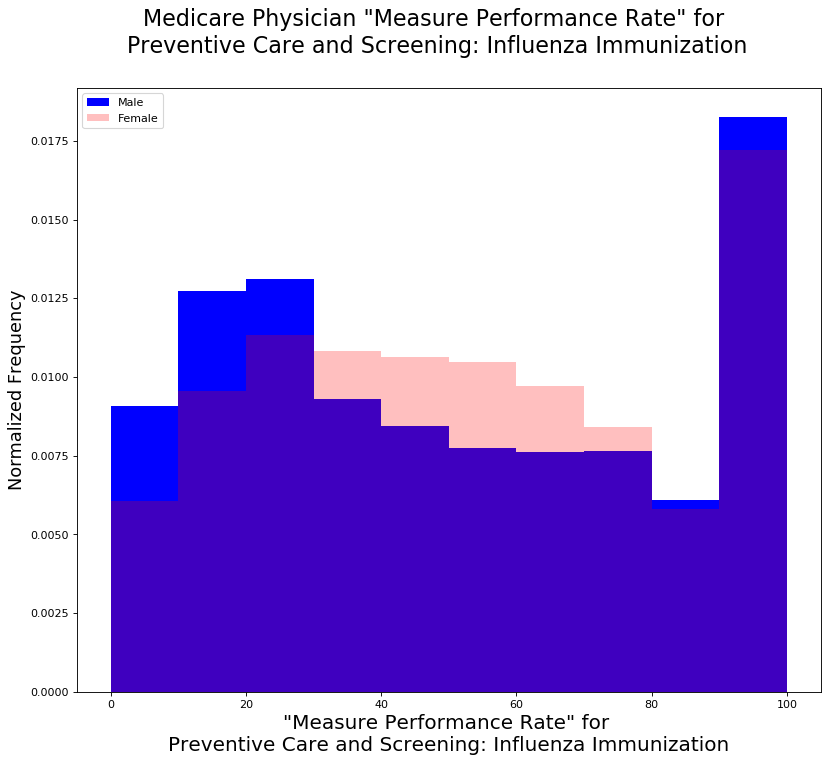

In [88]:
fig4=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
fig4.suptitle('Medicare Physician "Measure Performance Rate" for \nPreventive Care and Screening: Influenza Immunization', fontsize=20)
plt.xlabel('"Measure Performance Rate" for \nPreventive Care and Screening: Influenza Immunization', fontsize=18)
plt.ylabel('Normalized Frequency', fontsize=16)
ax7=plt.hist(flum['Measure_Performance_Rate'], label="Male", bins=d, color='blue', normed=True)
ax8=plt.hist(fluf['Measure_Performance_Rate'], label="Female", bins=d, color='red', normed=True, alpha=0.25)
plt.gca().legend()
plt.show()

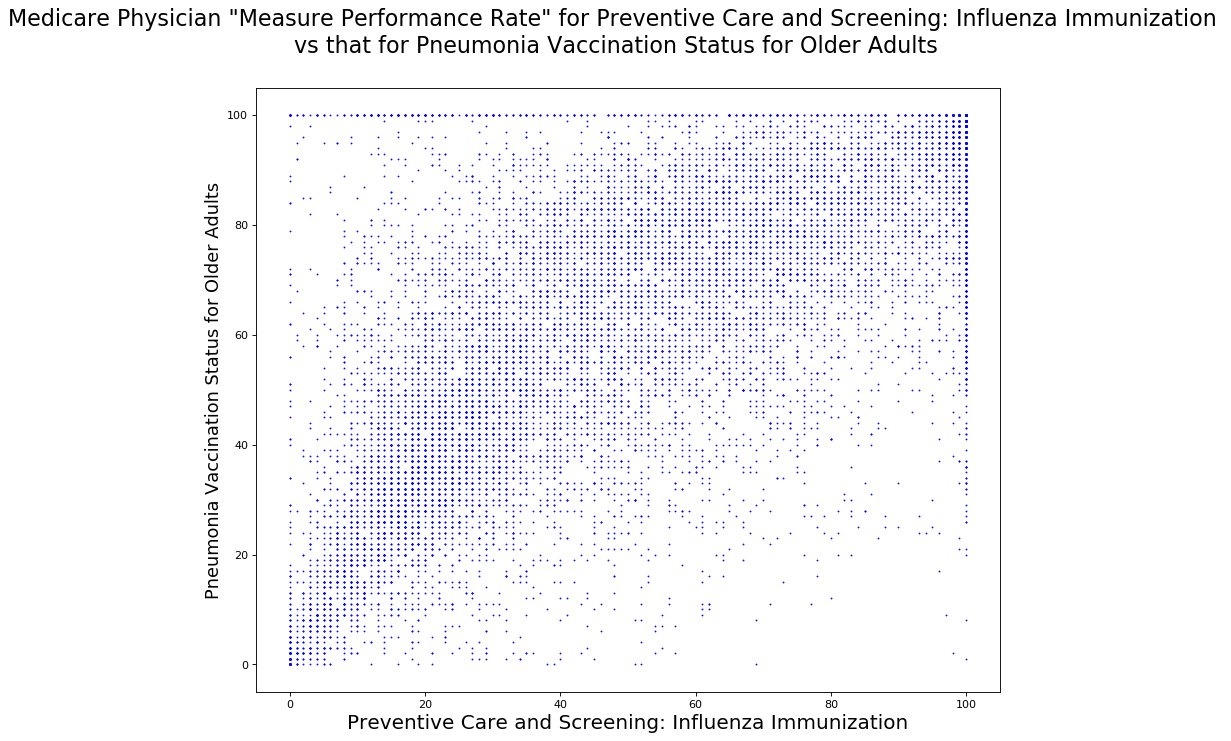

In [89]:
fig5=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
fig5.suptitle('Medicare Physician "Measure Performance Rate" for Preventive Care and Screening: Influenza Immunization \nvs that for Pneumonia Vaccination Status for Older Adults', fontsize=20)
plt.xlabel('Preventive Care and Screening: Influenza Immunization', fontsize=18)
plt.ylabel('Pneumonia Vaccination Status for Older Adults', fontsize=16)
ax9=plt.scatter(df23.Measure_Performance_Rate_x, df23.Measure_Performance_Rate_y, c=df23., s=0.4)
plt.show()

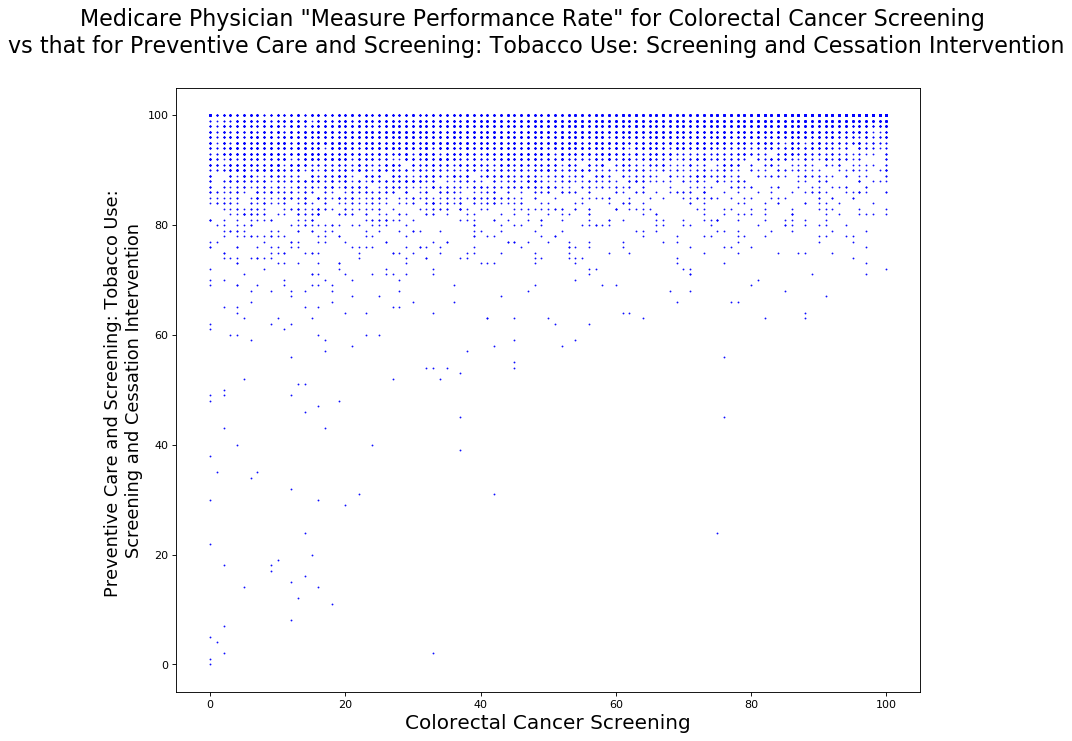

In [95]:
fig6=plt.figure(figsize=(12, 10), dpi= 80, facecolor='w', edgecolor='k')
fig6.suptitle('Medicare Physician "Measure Performance Rate" for Colorectal Cancer Screening \nvs that for Preventive Care and Screening: Tobacco Use: Screening and Cessation Intervention', fontsize=20)
plt.xlabel('Colorectal Cancer Screening', fontsize=18)
plt.ylabel('Preventive Care and Screening: Tobacco Use: \nScreening and Cessation Intervention', fontsize=16)
ax10=plt.scatter(df59.Measure_Performance_Rate_x, df59.Measure_Performance_Rate_y, c='blue', s=0.4)
plt.show()